In [1]:
import json
import multiprocessing
import os
import shutil
import time
import warnings

In [2]:
import cupy as cp
import gensim
import gensim.parsing.preprocessing as gsp
import joblib
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import pandas as pd
import tensorflow_hub as hub
from gensim.models import Word2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from keras import Input, Model
from keras.src.layers import Embedding, GlobalAveragePooling1D
from keras.src.utils import pad_sequences
from mlflow.models import infer_signature
from nltk import WordNetLemmatizer, PorterStemmer
from pandas import DataFrame
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from tf_keras.src.preprocessing.text import Tokenizer
from transformers import *
from xgboost import XGBClassifier

2024-09-06 16:54:46.735802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 16:54:46.747885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 16:54:46.751405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 16:54:46.761393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 16:54:47.570042: W tensorflow/compiler/tf2

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

MISC CONFIGURATION

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

NUMBER_OF_QUESTIONS_USED_IN_TRAINING = 10000

PATHS

In [5]:
CACHED_QUESTIONS_FILE = 'cached_questions.json'
MODELS_PATH = 'models/supervised'

NLTK PACKAGES

In [6]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/xavier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/xavier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

NLTK OBJECTS

In [7]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

To avoid having multiprocessing issues between BERT and the GridsearchCV

In [8]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [9]:
def load_cached_questions():
    """Load questions from the cache file."""
    with open(CACHED_QUESTIONS_FILE, 'r', encoding='utf-8') as f:
        return json.load(f)

In [10]:
def remove_last_saved_model():
    """Removes the content of the saved model."""
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH, exist_ok=True)

In [11]:
def extract_and_clean_text(question: dict):
    """Create a new 'text' field for each question containing the cleaned, tokenized and lemmatized title + body."""
    title = question['title']
    body = question['body']
    text = f"{title} {body}"
    
    for filter in [gsp.strip_tags,
                   gsp.strip_punctuation,
                   gsp.strip_multiple_whitespaces,
                   gsp.strip_numeric,
                   gsp.remove_stopwords,
                   gsp.strip_short,
                   gsp.lower_to_unicode]:
        text = filter(text)
        
    cleaned_text = text.replace("quot", "")
    tokenized_text = nltk.tokenize.word_tokenize(cleaned_text)

    # words_stemmed = (stemmer.stem(w) for w in words_without_short_words)
    words_lemmatized = [lemmatizer.lemmatize(w) for w in tokenized_text]
    question['text'] = " ".join(words_lemmatized)

    # bigrams = nltk.bigrams(tokenized_text)
    # question['bigrams'] = [' '.join(bigram) for bigram in bigrams]

    # trigrams = nltk.trigrams(tokenized_text)
    # question['trigrams'] = [' '.join(trigram) for trigram in trigrams]
    
    return question

In [12]:
def transform_text_using_BagOfWords(questions_without_tags, is_count_vectorizer=False):
    """Transform the text of the question's body and title into Word of bags embeddings."""
    time1 = time.time()

    model = CountVectorizer(stop_words='english', max_features=400) if is_count_vectorizer \
        else TfidfVectorizer(stop_words='english', max_features=400)

    embedded_text = model.fit_transform(questions_without_tags)

    time2 = np.round(time.time() - time1, 0)
    print(f"Word of bags processing time:{time2}s\n")
    return embedded_text.todense(), time2

In [13]:
def create_word2vec_embedding_matrix(model_vectors, vector_size, vocab_size, w2v_words, word_index):
    """Create the embedding matrix for the Word2Vec word embeddings method."""
    embedding_matrix = np.zeros((vocab_size, vector_size))
    
    i = 0
    j = 0
    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
                
    return embedding_matrix

In [14]:
def train_word2vec_embedding_model(embedding_matrix, maxlen, vector_size, vocab_size):
    """Train the word2vec embedding model."""
    word_input = Input(shape=(maxlen,), dtype='float64')

    word_embedding = Embedding(input_dim=vocab_size,
                               output_dim=vector_size,
                               weights=[embedding_matrix])(word_input)

    word_vec = GlobalAveragePooling1D()(word_embedding)
    embedding_model = Model([word_input], word_vec)

    return embedding_model

In [15]:
def train_w2v_model(sentences, vector_size):
    """Train the Word2Vec model"""
    w2v_model = gensim.models.Word2Vec(min_count=1, window=5,
                                       vector_size=vector_size,
                                       seed=42,
                                       workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100)
    
    return w2v_model

In [16]:
def transform_text_using_Word2Vec(questions_without_tags):
    """Transform the text of the question's body and title into Doc2VEC embeddings."""
    time1 = time.time()

    sentences = questions_without_tags
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

    vector_size = 300
    maxlen = max([len(sentence) for sentence in sentences])

    w2v_model = train_w2v_model(sentences, vector_size)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=maxlen, padding='post')

    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    embedding_matrix = create_word2vec_embedding_matrix(model_vectors, vector_size, vocab_size, w2v_words, word_index)
    embedding_model = train_word2vec_embedding_model(embedding_matrix, maxlen, vector_size, vocab_size)

    embedded_text = embedding_model.predict(x_sentences)

    time2 = np.round(time.time() - time1, 0)
    print(f"Doc2VEC processing time:{time2}s\n")
    return embedded_text, time2

In [17]:
def transform_text_using_Doc2VEC(questions_without_tags):
    """Transform the text of the question's body and title into Doc2VEC embeddings."""
    time1 = time.time()

    sentences = [gensim.utils.simple_preprocess(text) for text in questions_without_tags]
    tagged_text = [TaggedDocument(words=text, tags=[str(index)]) for index, text in enumerate(sentences)]

    # dm=0 for DBOW, dm=1 for PV-DM
    model = Doc2Vec(vector_size=300, min_count=1, epochs=100, dm=0)
    model.build_vocab(tagged_text)

    model.train(tagged_text, total_examples=model.corpus_count, epochs=model.epochs)
    embedded_text = [model.infer_vector(text) for text in sentences]

    time2 = np.round(time.time() - time1, 0)
    print(f"Doc2VEC processing time:{time2}s\n")

    return embedded_text, time2

In [18]:
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """Returns BERT variables for its prediction."""
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []
    
    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
        
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))
        
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [19]:
def transform_text_using_BERT(model, model_type, sentences, max_length, b_size):
    """Transform the text of the question's body and title into BERT embeddings."""
    # We don't want to use the cleaned text field with BERT, only title + " " + body
    sentences = [f"{sentence[1]} {sentence[0]}" for sentence in sentences.iterrows()]
    
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    
    time1 = time.time()
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx + batch_size],
                                                                               bert_tokenizer, max_length)
        outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
        
        last_hidden_states = outputs.last_hidden_state
        if step == 0:
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
            
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1, 0)
    print(f"BERT processing time:{time2}s\n")
    
    return features_bert, time2

In [20]:
def transform_text_using_USE(sentences, b_size):
    """Transform the text of the question's body and title into USE embeddings."""
    # We don't want to use the cleaned text field with USE, only title + " " + body
    sentences = [f"{sentence[1]} {sentence[0]}" for sentence in sentences.iterrows()]
    
    batch_size = b_size
    time1 = time.time()
    
    us_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        feat = us_encoder(sentences[idx:idx + batch_size])
        
        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))
            
    time2 = np.round(time.time() - time1, 0)
    print(f"USE processing time:{time2}s\n")
    
    return features, time2

In [21]:
def transform_text(questions_without_tags, text_transformation_method):
    """Transform the question text/body and title into words embeddings."""
    if text_transformation_method == "CountVectorizer":
        return transform_text_using_BagOfWords(questions_without_tags["text"], is_count_vectorizer=True)

    elif text_transformation_method == "TfidfVectorizer":
        return transform_text_using_BagOfWords(questions_without_tags["text"], is_count_vectorizer=False)

    elif text_transformation_method == "Word2Vec":
        return transform_text_using_Word2Vec(questions_without_tags["text"])

    elif text_transformation_method == "Doc2Vec":
        return transform_text_using_Doc2VEC(questions_without_tags["text"])

    elif text_transformation_method == "BERT":
        max_length = 64
        batch_size = 10
        model_type = 'bert-base-uncased'
        model = TFAutoModel.from_pretrained(model_type)

        return transform_text_using_BERT(model, model_type, questions_without_tags, max_length, batch_size)

    elif text_transformation_method == "USE":
        batch_size = 2
        return transform_text_using_USE(questions_without_tags, batch_size)

In [22]:
def create_results_plots(results):
    """Generate the plot showing the performances with each words embedding method."""
    create_results_plot(results, "jaccard_score", ascending=False)
    create_results_plot(results, "hamming_loss")
    create_results_plot(results, "embedding_time")
    create_results_plot(results, "fit_time")

In [23]:
def create_results_plot(results, metric, ascending=True):
    results.sort_values(metric, ascending=ascending, inplace=True)
    
    performance_plot = (results[[metric, "words_embedding_method"]]
                        .plot(kind="bar", x="words_embedding_method", figsize=(15, 8), rot=0,
                              title=f"Models Performance Sorted by {metric}"))
    performance_plot.title.set_size(20)
    performance_plot.set(xlabel=None)
    
    plt.show()
    plt.close()

In [24]:
def perform_supervised_modeling(questions):
    """Find the best model using a GridSearchCV hyperoptimization for each words embedding method."""
    questions_df = DataFrame(questions)

    tags = MultiLabelBinarizer().fit_transform(questions_df['tags'])
    # questions_df['tags'].to_json(f"{MODELS_PATH}/tags.json")

    questions_without_tags = questions_df.drop(columns=['tags'], axis=1)

    results_df = DataFrame(columns=["words_embedding_method", "hamming_loss", "jaccard_score", "embedding_time", "fit_time"])
    models = {}
    
    for words_embedding_method in [
        "CountVectorizer",
        "TfidfVectorizer",
        "Word2Vec",
        "Doc2Vec",
        "BERT",
        "USE"
    ]:
        print(f"Starting supervised learning of {NUMBER_OF_QUESTIONS_USED_IN_TRAINING} questions with words embedding method:{words_embedding_method}.\n")
        transformed_text, embedding_time = transform_text(questions_without_tags, words_embedding_method)

        x_train, x_test, y_train, y_test = train_test_split(transformed_text, tags, test_size=0.2, random_state=42)
        print(f"training set size:{len(x_train)}, test set size:{len(x_test)}\n")
        original_x_train = x_train

        if words_embedding_method not in ("BERT", "USE"):
            device = "cpu"
            nb_jobs = -1
        else:
            device = "cuda"
            nb_jobs = 1  # With cuda it's best to not parallelize jobs or -> cudaErrorMemoryAllocation
            x_train = cp.array(x_train)
            x_test = cp.array(x_test)
            

        # Best hyperparameters for 10k questions
        default_model = XGBClassifier(n_estimators=100, 
                                      max_depth=2, 
                                      device=device
                                     )
        default_hyperparameters = {'estimator__max_depth': range(2, 8)}

        fit_start_time = time.time()
        grid_search_cv = GridSearchCV(MultiOutputClassifier(estimator=default_model), default_hyperparameters,
                                      cv=2,
                                      scoring=make_scorer(metrics.jaccard_score, average='samples'),
                                      n_jobs=nb_jobs,  
                                      verbose=3
                                      )

        grid_search_cv.fit(x_train, y_train)
        best_model = grid_search_cv.best_estimator_
        best_parameters = grid_search_cv.best_params_
        print(f"\nBest Jaccard score:{grid_search_cv.best_score_} with params:{best_parameters}")

        # In case of simply training the model
        # default_model.fit(x_train, cp.array(y_train))
        # best_model = default_model
        
        fit_time = np.round(time.time() - fit_start_time, 0)
        
        models[words_embedding_method] = best_model
        
        predictions_test_y = best_model.predict(x_test)
        hamming_loss = metrics.hamming_loss(y_true=y_test, y_pred=predictions_test_y)
        jaccard_score = metrics.jaccard_score(y_true=y_test, y_pred=predictions_test_y, average='samples')
        print(f"Hamming loss:{hamming_loss}, jaccard_score:{jaccard_score}\n")

        # training set size:36000, test set size:9000, XGBClassifier and USE
        # Hamming loss:0.0002497610080278267, jaccard_score:0.30443386243386245

        results_df.loc[len(results_df)] = [words_embedding_method, hamming_loss, jaccard_score, embedding_time, fit_time]

        send_results_to_mlflow(best_model, hamming_loss, jaccard_score, words_embedding_method, original_x_train, embedding_time, fit_time)

    create_results_plots(results_df)

    save_best_model(models, results_df)

In [25]:
def send_results_to_mlflow(best_model, hamming_loss, jaccard_score, words_embedding_method,
                           x_train, embedding_time, fit_time):
    """Send data to the MLFlow server."""
    with mlflow.start_run():
        mlflow.log_params({"words_embedding_method": words_embedding_method})
        
        mlflow.log_metric("hamming_loss", hamming_loss)
        mlflow.log_metric("jaccard_score", jaccard_score)
        mlflow.log_metric("embedding_time", embedding_time)
        mlflow.log_metric("fitting_time", fit_time)
        
        mlflow.set_tag("Words embedding method", words_embedding_method)
        
        signature = infer_signature(x_train, best_model.predict(x_train))
        
        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path="supervised-models",
            signature=signature,
            input_example=x_train,
            registered_model_name="XGBoostClassifier",
        )

In [26]:
def save_best_model(models, results_df):
    """Save the best model based on the hamming loss."""
    best_words_embedding_method = results_df.head(1)['words_embedding_method'].values[0]
    joblib.dump(models[best_words_embedding_method], f"{MODELS_PATH}/best_supervised_model.model")

Starting supervised learning script. Please make sure you have a local MLFlow server running, the README file has more information about this.

10000 questions loaded from cache.

Texts extracted and cleaned.

Starting supervised learning of 10000 questions with words embedding method:CountVectorizer.

Word of bags processing time:0.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 2/2] END ............estimator__max_depth=4;, score=0.282 total time=23.5min
[CV 2/2] END ............estimator__max_depth=6;, score=0.281 total time=24.4min
[CV 1/2] END ............estimator__max_depth=3;, score=0.282 total time=24.5min
[CV 1/2] END ............estimator__max_depth=5;, score=0.283 total time=24.9min
[CV 2/2] END ............estimator__max_depth=2;, score=0.280 total time=27.3min
[CV 1/2] END ............estimator__max_depth=7;, score=0.282 total time=27.7min
[CV 2/2] END ............estimator__max_depth=7;, score=0.282 total tim

Registered model 'XGBoostClassifier' already exists. Creating a new version of this model...
2024/09/06 17:31:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 5
Created version '5' of model 'XGBoostClassifier'.
2024/09/06 17:31:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-wren-32 at: http://localhost:8080/#/experiments/824583367597410287/runs/f813d27fb02b4c64a4654d8db4f16922.
2024/09/06 17:31:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/824583367597410287.


Starting supervised learning of 10000 questions with words embedding method:TfidfVectorizer.

Word of bags processing time:0.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ............estimator__max_depth=2;, score=0.282 total time=28.9min
[CV 2/2] END ............estimator__max_depth=6;, score=0.280 total time=29.0min
[CV 1/2] END ............estimator__max_depth=4;, score=0.282 total time=30.1min
[CV 1/2] END ............estimator__max_depth=6;, score=0.283 total time=30.3min
[CV 2/2] END ............estimator__max_depth=7;, score=0.281 total time=30.6min
[CV 1/2] END ............estimator__max_depth=5;, score=0.285 total time=32.1min
[CV 1/2] END ............estimator__max_depth=3;, score=0.281 total time=32.3min
[CV 2/2] END ............estimator__max_depth=2;, score=0.282 total time=32.6min
[CV 2/2] END ............estimator__max_depth=5;, score=0.280 total time=32.8min
[CV 2/2] END ............estimator__ma

Registered model 'XGBoostClassifier' already exists. Creating a new version of this model...
2024/09/06 18:25:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 6
Created version '6' of model 'XGBoostClassifier'.
2024/09/06 18:25:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-fox-54 at: http://localhost:8080/#/experiments/824583367597410287/runs/5482c1a1ccf44fc7890e1d20b788daef.
2024/09/06 18:25:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/824583367597410287.


Starting supervised learning of 10000 questions with words embedding method:Word2Vec.



I0000 00:00:1725621982.581664  209998 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725621982.630902  209998 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725621982.633694  209998 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725621982.637120  209998 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

204/313 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step

I0000 00:00:1725621983.056090  232111 service.cc:146] XLA service 0x7f000c003c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725621983.056125  232111 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-09-06 18:26:23.087258: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1725621983.131555  232111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
Doc2VEC processing time:25.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 2/2] END ............estimator__max_depth=4;, score=0.213 total time=37.8min
[CV 2/2] END ............estimator__max_depth=3;, score=0.219 total time=38.4min
[CV 1/2] END ............estimator__max_depth=5;, score=0.210 total time=41.2min
[CV 2/2] END ............estimator__max_depth=6;, score=0.206 total time=41.9min
[CV 1/2] END ............estimator__max_depth=3;, score=0.225 total time=45.8min
[CV 1/2] END ............estimator__max_depth=2;, score=0.230 total time=46.3min
[CV 2/2] END ............estimator__max_depth=2;, score=0.227 total time=46.6min
[CV 1/2] END ............estimator__max_depth=7;, score=0.203 total time=47.8min
[CV 1/2] END ............estimator__max_depth=4;, score=0.215 total time=47.8min
[CV 2/2] END ............estimator__max_depth=5;, score=0.207 total time=47.9min
[CV 2/2] END

Registered model 'XGBoostClassifier' already exists. Creating a new version of this model...
2024/09/06 19:41:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 7
Created version '7' of model 'XGBoostClassifier'.
2024/09/06 19:41:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-crane-163 at: http://localhost:8080/#/experiments/824583367597410287/runs/dd756107fad545229b972bbf909a9304.
2024/09/06 19:41:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/824583367597410287.


Starting supervised learning of 10000 questions with words embedding method:Doc2Vec.

Doc2VEC processing time:92.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 2/2] END ............estimator__max_depth=5;, score=0.130 total time=40.8min
[CV 1/2] END ............estimator__max_depth=4;, score=0.136 total time=43.2min
[CV 2/2] END ............estimator__max_depth=4;, score=0.138 total time=43.5min
[CV 1/2] END ............estimator__max_depth=6;, score=0.117 total time=44.4min
[CV 1/2] END ............estimator__max_depth=7;, score=0.114 total time=44.9min
[CV 2/2] END ............estimator__max_depth=3;, score=0.151 total time=46.0min
[CV 1/2] END ............estimator__max_depth=2;, score=0.159 total time=46.3min
[CV 2/2] END ............estimator__max_depth=7;, score=0.114 total time=46.5min
[CV 2/2] END ............estimator__max_depth=2;, score=0.161 total time=47.4min
[CV 1/2] END ............estimator__max_depth=5;, 

Registered model 'XGBoostClassifier' already exists. Creating a new version of this model...
2024/09/06 21:06:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 8
Created version '8' of model 'XGBoostClassifier'.
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

2024/09/06 21:06:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-seal-634 at: http://localhost:8080/#/experiments/824583367597410287/runs/2dd4824b424b4ce6a0e6b0efff8a84cd.
2024/09/06 21:06:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/824583367597410287.


Starting supervised learning of 10000 questions with words embedding method:BERT.



loading configuration file config.json from cache at /home/xavier/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /home/xavier/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f72

1/1 [==============================] - 0s 19ms/step
BERT processing time:205.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ............estimator__max_depth=2;, score=0.117 total time= 7.1min
[CV 2/2] END ............estimator__max_depth=2;, score=0.119 total time= 7.1min
[CV 1/2] END ............estimator__max_depth=3;, score=0.110 total time= 7.4min
[CV 2/2] END ............estimator__max_depth=3;, score=0.112 total time= 7.4min
[CV 1/2] END ............estimator__max_depth=4;, score=0.104 total time= 7.6min
[CV 2/2] END ............estimator__max_depth=4;, score=0.104 total time= 7.6min
[CV 1/2] END ............estimator__max_depth=5;, score=0.099 total time= 7.7min
[CV 2/2] END ............estimator__max_depth=5;, score=0.094 total time= 7.7min
[CV 1/2] END ............estimator__max_depth=6;, score=0.093 total time= 7.8min
[CV 2/2] END ............estimator__max_depth=6;, score=0.094 total time= 7.7min
[CV 1

/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:51:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
Registered model 'XGBoostClassifier' already exists. Creating a new version of this model...
2024/09/06 22:54:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 9
Created version '9' of model 'XGBoostClassifier'.
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the cl

Starting supervised learning of 10000 questions with words embedding method:USE.

USE processing time:25.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ............estimator__max_depth=2;, score=0.258 total time= 5.7min
[CV 2/2] END ............estimator__max_depth=2;, score=0.245 total time= 5.7min
[CV 1/2] END ............estimator__max_depth=3;, score=0.251 total time= 5.9min
[CV 2/2] END ............estimator__max_depth=3;, score=0.241 total time= 5.9min
[CV 1/2] END ............estimator__max_depth=4;, score=0.250 total time= 6.0min
[CV 2/2] END ............estimator__max_depth=4;, score=0.239 total time= 6.0min
[CV 1/2] END ............estimator__max_depth=5;, score=0.246 total time= 6.1min
[CV 2/2] END ............estimator__max_depth=5;, score=0.236 total time= 6.1min
[CV 1/2] END ............estimator__max_depth=6;, score=0.247 total time= 6.1min
[CV 2/2] END ............estimator__max_depth=6;, score=0.

Registered model 'XGBoostClassifier' already exists. Creating a new version of this model...
2024/09/07 00:17:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 10
Created version '10' of model 'XGBoostClassifier'.
2024/09/07 00:19:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-stork-539 at: http://localhost:8080/#/experiments/824583367597410287/runs/ba868042183e4e069ce43356d8b45b3c.
2024/09/07 00:19:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/824583367597410287.


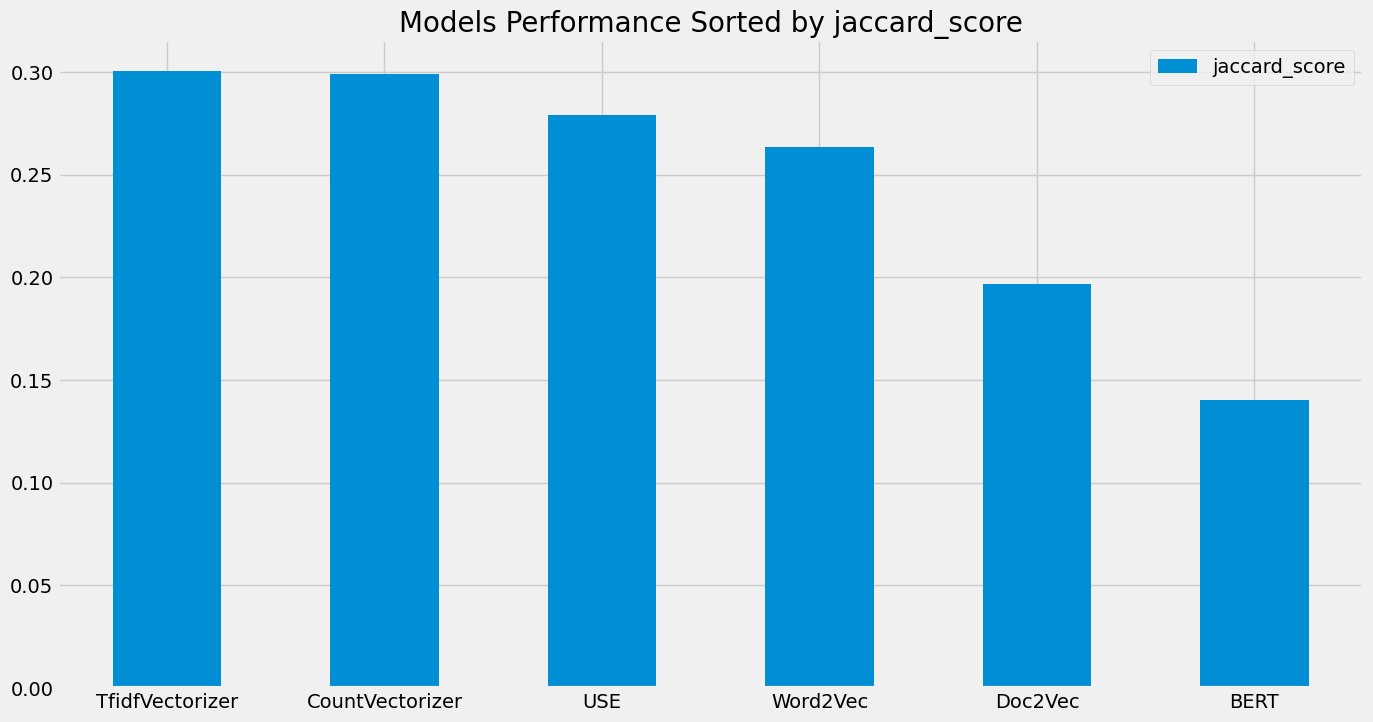

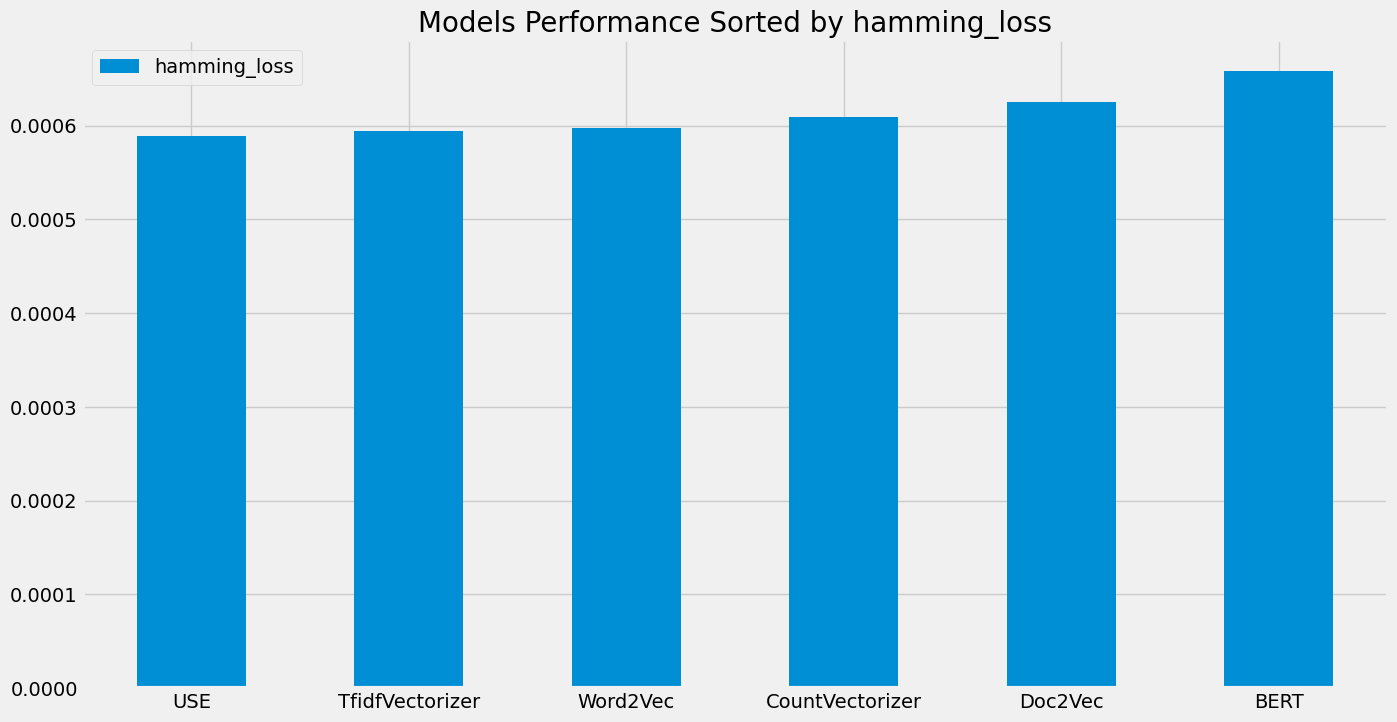

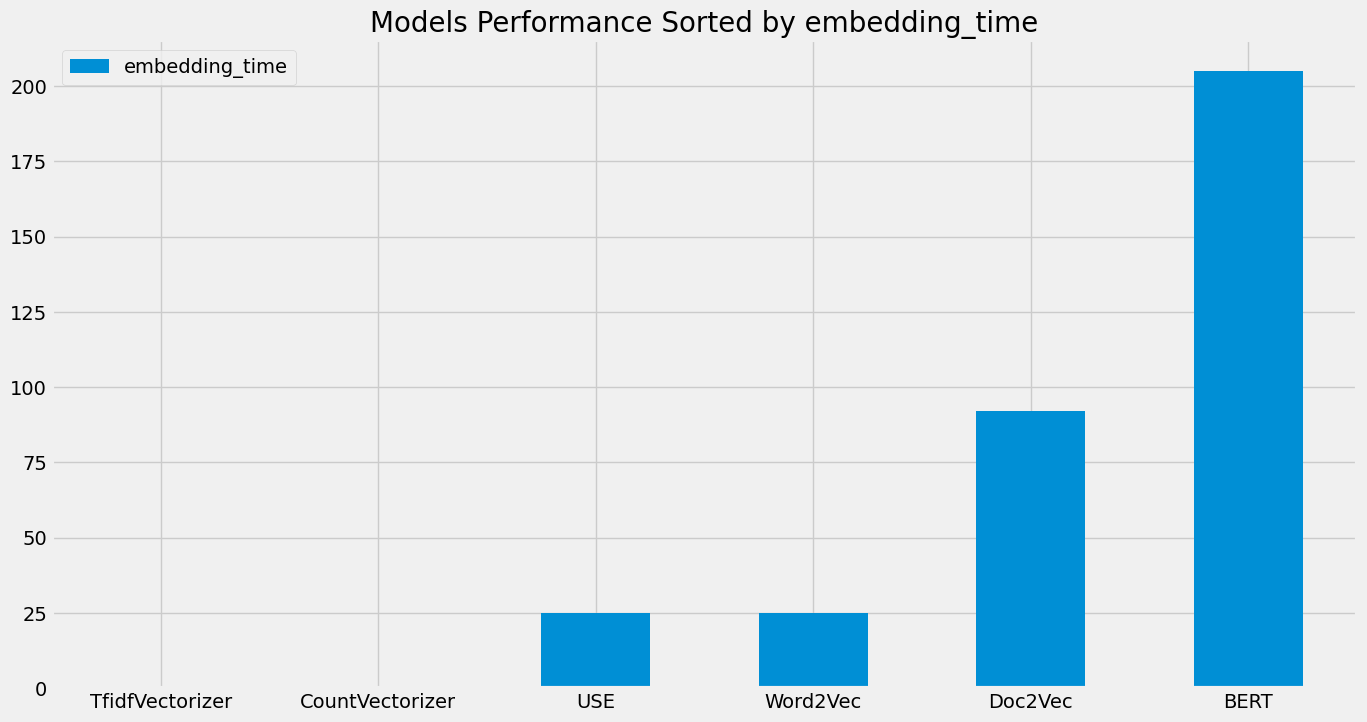

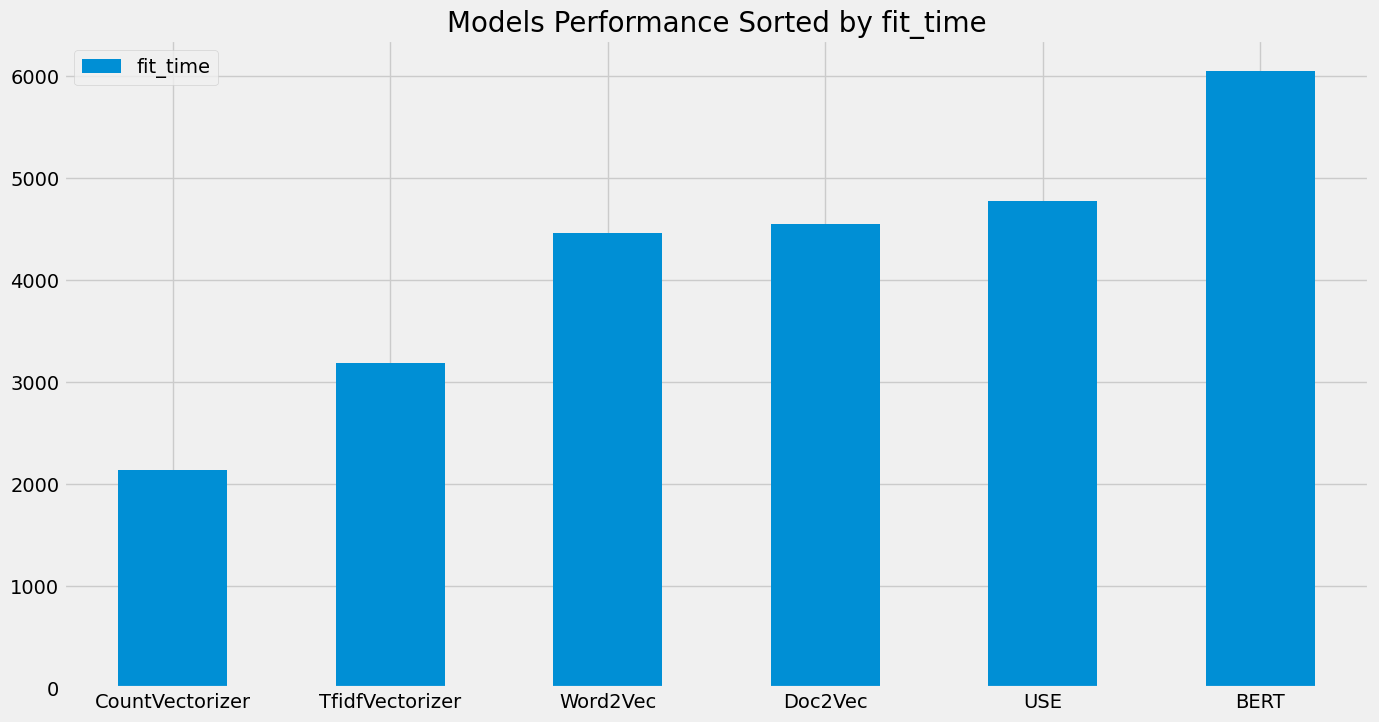


Supervised learning now finished.



In [27]:
print("Starting supervised learning script. Please make sure you have a local MLFlow server running, the README file has more information about this.\n")
remove_last_saved_model()

mlflow.set_tracking_uri(uri="http://localhost:8080")
mlflow.set_experiment("Supervised Learning Experiment")

json_questions = load_cached_questions()

questions = [{
    "body": question['body'],
    "tags": question['tags'],
    "title": question['title']
} for question in json_questions[:NUMBER_OF_QUESTIONS_USED_IN_TRAINING]]

print(f"{len(questions)} questions loaded from cache.\n")

questions = list(map(extract_and_clean_text, questions))
print("Texts extracted and cleaned.\n")

perform_supervised_modeling(questions)

print("\nSupervised learning now finished.\n")